In [11]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from math import sin,cos

In [12]:
def load_data(filename):
    dataset=np.load(filename)
    t=dataset['t']
    x_true=dataset['x_true']
    y_true=dataset['y_true']
    th_true=dataset['th_true']
    l=dataset['l']
    r=dataset['r']
    r_var=dataset['r_var']
    b=dataset['b']
    b_var=dataset['b_var']
    v=dataset['v']
    v_var=dataset['v_var']
    om=dataset['om']
    om_var=dataset['om_var']
    d=dataset['d']
    return t, x_true, y_true, th_true, l, r, r_var, b, b_var, v, v_var, om, om_var, d

t,x_true,y_true,th_true,l,r,r_var,b,b_var,v,v_var,om,om_var,d=load_data('dataset.npz')

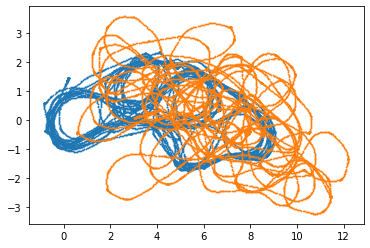

In [13]:
def simpleOdometry(x0,y0,th0,v,om):
    X=np.array([x0,y0,th0])
#     print(X.shape)
    delt=0.1
    x_new=[]
    y_new=[]
    for i in range(len(x_true)):
        X=X+np.array([[-v[i][0]*sin(X[2])/om[i][0]+v[i][0]*sin(X[2]+om[i][0]*delt)/om[i][0]],
                      [v[i][0]*cos(X[2])/om[i][0]-v[i][0]*cos(X[2]+om[i][0]*delt)/om[i][0]],
                      [om[i][0]*delt]])
        x_new.append(X[0])
        y_new.append(X[1])
    x_odo=np.array(x_new)
    y_odo=np.array(y_new)
    return x_odo,y_odo

x_odo,y_odo=simpleOdometry(x_true[0],y_true[0],th_true[0],v,om)
plt.figure()
plt.scatter(x_true,y_true,s=0.5,label='true')
plt.scatter(x_odo,y_odo,s=0.5,label='odometry')
plt.show()

In [14]:
def prediction_step(mu_prev,sig_prev,u,v_var,om_var):
    delt=0.1
    v=u[0]
    om=u[1]
    X=deepcopy(mu_prev)
    update=np.array([[-v*sin(X[2])/om+v*sin(X[2]+om*delt)/om],
                      [v*cos(X[2])/om-v*cos(X[2]+om*delt)/om],
                      [om*delt]])
    mu_dash=mu_prev+update
    Jacobian3=np.array([[-v*cos(X[2])/om+v*cos(X[2]+om*delt)/om],
                      [-v*sin(X[2])/om-v*sin(X[2]+om*delt)/om],
                      [0]])
    M=np.hstack((np.zeros((3,2)),Jacobian3))
    G=np.eye(3,3)+M
    R=np.diag(np.array([v_var,v_var,om_var]))
    sig_dash=G.dot(sig_prev.dot(G.T))+R
    return mu_dash,sig_dash

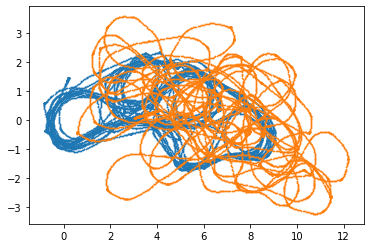

In [15]:
# testing predction step
mu_init=np.array([x_true[0][0],y_true[0][0],th_true[0][0]]).reshape(3,1)
sig_init=np.diag([1,1,0.1])
mu_prev=deepcopy(mu_init)
sig_prev=deepcopy(sig_init)
x_pred=[]
y_pred=[]
timesteps=len(t)
for i in range(1,timesteps):
    # print(i)
    mu_prev,sig_prev=prediction_step(mu_prev,sig_prev,[v[i][0],om[i][0]],v_var[0][0],om_var[0][0])
    x_pred.append(mu_prev[0])
    y_pred.append(mu_prev[1])
plt.figure()
plt.scatter(x_true,y_true,s=0.5,label='true')
plt.scatter(x_pred,y_pred,s=0.5,label='predicted')
plt.show()

In [17]:
def update_step(l,r,b,mu_dash,sig_dash,d,r_var,b_var):
    R=np.diag([r_var,b_var]*17)
    gnd_view=np.array([0.0]*34).reshape(34,1)
    robot_view=np.array([0.0]*34).reshape(34,1)
    jacobian=np.zeros((34,3))
    for i in range(17):
        gnd_view[2*i]=r[i]
        gnd_view[2*i+1]=b[i]
        if r[i]!=0:
#             potherrint (l[i].shape)
            robot_view[2*i]=((l[i,0]-mu_dash[0]-d*np.cos(mu_dash[2]))**2+(l[i,1]-mu_dash[1]-d*np.sin(mu_dash[2]))**2)**(1/2)
            robot_view[2*i+1]=np.arctan2(l[i,1]-mu_dash[1]-d*np.sin(mu_dash[2]),l[i][0]-mu_dash[0]-d*np.cos(mu_dash[2]))
            
        if robot_view[2*i] and robot_view[2*i+1] != 0:
            robot_view[2*i+1] -= mu_dash[2]
        while robot_view[2*i+1]>np.pi:
                robot_view[2*i+1]-=2*np.float64(np.pi)
        while robot_view[2*i+1]<=-np.pi:
                robot_view[2*i+1]+=2*np.float64(np.pi)
        x = mu_dash[0]
        y = mu_dash[1]
        angle = mu_dash[2]
        distance = d
        dx=l[i][0]-x-distance*np.cos(angle)
        dy=l[i][1]-y-distance*np.cos(angle)
        div=np.sqrt(dx**2+dy**2)
        jacobian[2*i][0]=-dx/div
        jacobian[2*i][1]=-dy/div
        jacobian[2*i][2]=((dx*sin(angle)-dy*cos(angle))/div)*distance
        jacobian[2*i+1][0]=dy/(div**2)
        jacobian[2*i+1][1]=-dx/(div**2)
        jacobian[2*i+1][2]=-((dx*cos(angle)+dy*sin(angle))/(div**2))*d-1


    K=sig_dash.dot(jacobian.T).dot(np.linalg.pinv(jacobian.dot(sig_dash.dot(jacobian.T))+R))
    mu=mu_dash+1*K.dot(gnd_view-robot_view)
    sig=(np.eye(3)-K.dot(jacobian)).dot(sig_dash)
    return mu,sig


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113


3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785


5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483


6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154


8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813


10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
1041

11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
1182

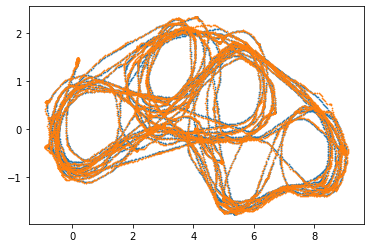

In [18]:
# testing predction step
mu_init=np.array([x_true[0][0],y_true[0][0],th_true[0][0]]).reshape(3,1)
sig_init=np.diag([1,1,0.1])
mu_prev=deepcopy(mu_init)
sig_prev=deepcopy(sig_init)
x_pred=[]
y_pred=[]
timesteps=len(t)
for i in range(1,12609):
    print(i)
    mu_dash,sig_dash=prediction_step(mu_prev,sig_prev,[v[i][0],om[i][0]],v_var[0][0],om_var[0][0])
#     print (l.shape)
    mu_prev,sig_prev=update_step(l,r[i],b[i],mu_dash,sig_dash,d,r_var[0],b_var[0])
    x_pred.append(mu_prev[0])
    y_pred.append(mu_prev[1])
plt.figure()
plt.scatter(x_true,y_true,s=0.5,label='true')
plt.scatter(x_pred,y_pred,s=0.5,label='predicted')
plt.show()

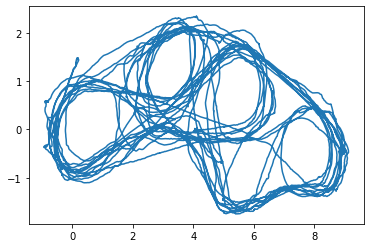

In [19]:
plt.plot(x_pred,y_pred,label='predicted')
